Implement various metrics to evaluate the performance of the RL model & H-network on how good they can mask user's load

Tentative metrics

Privacy metrics
- Mutual Information (either follows paper's evaluation, or other methods?)
- Matthews correlation coefficient (MCC) ? But we need to train an attacker as well. (Ruichang used this in a previous paper, PLS-DDPG)
- KL-divergence? Should be easy to compute

Monetary Cost metrics
- Compute the extra cost incured for the battery operation (i.e. compute the masked load vs original grid load)

In [13]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import json
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import matplotlib
# matplotlib.use('Agg')       # Use non-interactive backend for matplotlib to save memory
# matplotlib.use('inline')       # Use interactive backend for matplotlib

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

---

Load the train/valid/test per-episode log

In [3]:
expt_datetime = datetime(2025, 7, 19, 3, 30, 35)
result_phrase = "train"  # or "test" or "validate"

expt_folder = Path("experiments") / expt_datetime.strftime("%Y%m%d_%H%M%S") / ("logs_" + result_phrase)

if not expt_folder.exists():
    print_log(f"Experiment folder {expt_folder} does not exist. Please check the path.", "error")

In [4]:
env_config_path = expt_folder / "env_config.json"
if not env_config_path.exists():
    print_log(f"Environment config file {env_config_path} does not exist. Please check the path.", "error")

# Load environment configuration
with open(env_config_path, 'r') as f:
    env_config = json.load(f)

# Display environment configuration
print_log("Environment Configuration:")
for key, value in env_config.items():
    print_log(f"{key}: {value}")

[2025-07-23 13:49:37:321] Environment Configuration:
[2025-07-23 13:49:37:321] battery: {'capacity': 8.0, 'max_charging_rate': 4.0, 'max_discharging_rate': 4.0, 'efficiency': 1.0, 'initial_soc': 1.0}
[2025-07-23 13:49:37:321] reward_lambda: 0.5
[2025-07-23 13:49:37:321] h_network_type: HNetworkType.H_NETWORK2
[2025-07-23 13:49:37:321] init_soc: 0.15


In [5]:
max_battery_capacity = env_config.get("battery").get("capacity", 8)
max_battery_capacity

8.0

In [6]:
episode_info_folder = expt_folder / "episode_info"
if episode_info_folder.exists():
    episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
    episode_info_dfs = []

    for file in episode_info_files:
        with open(file, "r") as f:
            episode_info = json.load(f)
            df = pd.DataFrame(episode_info)
            # add a column for the episode number
            df['episode'] = int(file.stem.split('_')[1])  # Assuming the file name is like "episode_0_info.json", "episode_1_info.json", etc.
            # convert the datetime strings to datetime objects using python isoformat
            df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')

            # temporary fix
            # rename the battery_soc (kWh) column to battery_soc (%)
            df.rename(columns={"battery_soc (kWh)": "battery_soc (%)"}, inplace=True)
            # compute the battery_soc (kWh) column
            df['battery_soc (kWh)'] = df['battery_soc (%)'] * max_battery_capacity  # Assuming the battery capacity is 8 kWh


            episode_info_dfs.append(df)

            print_log(f"Loaded episode info from {file.name}")

    # Concatenate all DataFrames into one
    episode_info_df = pd.concat(episode_info_dfs, ignore_index=True)
    

[2025-07-23 13:49:37:363] Loaded episode info from episode_0001_info.json
[2025-07-23 13:49:37:370] Loaded episode info from episode_0002_info.json
[2025-07-23 13:49:37:378] Loaded episode info from episode_0003_info.json
[2025-07-23 13:49:37:384] Loaded episode info from episode_0004_info.json
[2025-07-23 13:49:37:390] Loaded episode info from episode_0005_info.json
[2025-07-23 13:49:37:397] Loaded episode info from episode_0006_info.json
[2025-07-23 13:49:37:403] Loaded episode info from episode_0007_info.json
[2025-07-23 13:49:37:409] Loaded episode info from episode_0008_info.json
[2025-07-23 13:49:37:416] Loaded episode info from episode_0009_info.json
[2025-07-23 13:49:37:422] Loaded episode info from episode_0010_info.json
[2025-07-23 13:49:37:428] Loaded episode info from episode_0011_info.json
[2025-07-23 13:49:37:434] Loaded episode info from episode_0012_info.json
[2025-07-23 13:49:37:441] Loaded episode info from episode_0013_info.json
[2025-07-23 13:49:37:446] Loaded episo

Run the following cells

Mutual Information implementation

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#r50b872b699c4-2

In the paper `Privacy-Cost Management in Smart Meters With Mutual-Information-Based Reinforcement Learning`, the parameter $k$ (in KNN estimation) is set to 4

X will be the masked grid load; y will be the user load

In [26]:
def calculate_mutual_information_per_episode(episode_info_dfs, k=4):
    """
    Calculate mutual information between masked grid load and user load for each episode.
    
    Args:
        episode_info_dfs: List of episode DataFrames
        k: Number of neighbors for KNN estimation (default=4 as per paper)
    
    Returns:
        Dictionary containing:
        - 'mi_values': List of mutual information values for each episode
        - 'episode_indices': List of episode indices from the dataset
        - 'episode_info_indices': List of indices in the episode_info_dfs list
    """
    mi_results = {
        'mi_values': [],
        'episode_indices': [],
        'episode_info_indices': []
    }
    
    for i, episode_df in enumerate(episode_info_dfs):
        try:
            # Get the episode index from the dataframe
            episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else episode_df['episode'].iloc[0]
            
            # Create a copy to avoid modifying the original dataframe
            df_clean = episode_df.copy()
            
            # Remove rows with NaN values in either grid_load or user_load columns
            df_clean = df_clean.dropna(subset=['grid_load (W)', 'user_load (W)'])
            
            # Check if we have enough data points after removing NaN values
            if len(df_clean) < k + 1:  # Need at least k+1 points for KNN
                print_log(f"Episode {i} (episode_idx: {episode_idx}): Not enough valid data points ({len(df_clean)}) after removing NaN values")
                mi_results['mi_values'].append(np.nan)
                mi_results['episode_indices'].append(episode_idx)
                mi_results['episode_info_indices'].append(i)
                continue
            
            # Extract the features: masked grid load (X) and user load (y)
            X = df_clean['grid_load (W)'].values.reshape(-1, 1)  # Masked grid load (features)
            y = df_clean['user_load (W)'].values  # User load (continuous target)
            
            # Calculate mutual information using scikit-learn for regression
            # mutual_info_regression handles continuous variables directly
            mi = mutual_info_regression(X, y, n_neighbors=k, random_state=42)
            
            mi_results['mi_values'].append(mi[0])  # mi is an array, we take the first element
            mi_results['episode_indices'].append(episode_idx)
            mi_results['episode_info_indices'].append(i)
            
            if i % 100 == 0:  # Print progress every 100 episodes
                print_log(f"Processed episode {i}/{len(episode_info_dfs)} (episode_idx: {episode_idx})")

            del df_clean  # Free memory after processing
                
        except Exception as e:
            # Get episode index even in case of error
            episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else i
            print_log(f"Error calculating MI for episode {i} (episode_idx: {episode_idx}): {str(e)}")
            mi_results['mi_values'].append(np.nan)  # Add NaN for failed calculations
            mi_results['episode_indices'].append(episode_idx)
            mi_results['episode_info_indices'].append(i)
    
    print_log(f"Calculated mutual information for {len(mi_results['mi_values'])} episodes")
    return mi_results

In [27]:
# Calculate mutual information for all episodes
print_log("Starting mutual information calculation...")
mi_results = calculate_mutual_information_per_episode(episode_info_dfs, k=4)

# Extract the components from the results
mutual_info_values = mi_results['mi_values']
episode_indices = mi_results['episode_indices']
episode_info_indices = mi_results['episode_info_indices']

# Create a comprehensive DataFrame with episode, episode_index, and MI values
mi_df = pd.DataFrame({
    'episode_info_index': episode_info_indices,         # Index in the episode_info_dfs list
    'episode_index': episode_indices,                   # Episode index from the dataset
    'mutual_information': mutual_info_values            # MI values
})

print_log(f"Mutual Information Statistics:")
print_log(f"Mean MI: {np.nanmean(mutual_info_values):.6f}")
print_log(f"Std MI: {np.nanstd(mutual_info_values):.6f}")
print_log(f"Min MI: {np.nanmin(mutual_info_values):.6f}")
print_log(f"Max MI: {np.nanmax(mutual_info_values):.6f}")

print_log(f"DataFrame shape: {mi_df.shape}")
print_log(f"Episode index range: {mi_df['episode_index'].min()} to {mi_df['episode_index'].max()}")

mi_df.head()

[2025-07-23 14:28:21:594] Starting mutual information calculation...
[2025-07-23 14:28:21:600] Processed episode 0/1009 (episode_idx: 96)
[2025-07-23 14:28:21:981] Processed episode 100/1009 (episode_idx: 42)
[2025-07-23 14:28:21:981] Processed episode 100/1009 (episode_idx: 42)
[2025-07-23 14:28:22:368] Processed episode 200/1009 (episode_idx: 75)
[2025-07-23 14:28:22:368] Processed episode 200/1009 (episode_idx: 75)
[2025-07-23 14:28:22:744] Processed episode 300/1009 (episode_idx: 42)
[2025-07-23 14:28:22:744] Processed episode 300/1009 (episode_idx: 42)
[2025-07-23 14:28:23:132] Processed episode 400/1009 (episode_idx: 58)
[2025-07-23 14:28:23:132] Processed episode 400/1009 (episode_idx: 58)
[2025-07-23 14:28:23:499] Processed episode 500/1009 (episode_idx: 150)
[2025-07-23 14:28:23:499] Processed episode 500/1009 (episode_idx: 150)
[2025-07-23 14:28:23:891] Processed episode 600/1009 (episode_idx: 80)
[2025-07-23 14:28:23:891] Processed episode 600/1009 (episode_idx: 80)
[2025-07

,episode_info_index,episode_index,mutual_information
0,0,96,0.499336
1,1,8,0.578894
2,2,147,0.557033
3,3,35,0.460014
4,4,41,0.418298


In [37]:
def plot_episode_with_psd(episode_df, episode_idx, mi_value, save_path=None, use_datetime=False, show=True):
    """
    Plot episode details with user load, grid load, and Power Spectral Density of masked grid load
    
    Args:
        episode_df: DataFrame containing episode information
        episode_idx: Episode index for title
        mi_value: Mutual information value for this episode (displayed as text)
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), dpi=150)
    
    # Determine x-axis values for the top plot
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0]  # Get the episode iteration number for title
    
    # First subplot: User load and Grid load (same as in expt_results.ipynb)
    ax1.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2)
    ax1.plot(x_values, episode_df['grid_load (W)'], label='Grid Load (Masked)', color='pink', linewidth=2, alpha=0.8)

    ax1.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Load Profiles Over Time (MI = {mi_value:.6f})')
    ax1.set_ylabel('Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second subplot: Power Spectral Density of masked grid load using Welch's method
    # Handle the index shift - masked load appears at iloc[1:]
    # Extract the masked grid load data, removing NaN values
    masked_load_data = episode_df['grid_load (W)'].dropna().values
    
    if len(masked_load_data) > 10:  # Need sufficient data for PSD
        # Calculate sampling frequency (assuming regular intervals)
        # If we have datetime, calculate from actual time differences
        if use_datetime and 'datetime' in episode_df.columns:
            # Calculate average time difference in seconds
            time_diffs = episode_df['datetime'].diff().dt.total_seconds().dropna()
            if len(time_diffs) > 0:
                avg_dt = time_diffs.mean()
                fs = 1.0 / avg_dt  # Sampling frequency in Hz
            else:
                fs = 1.0 / 6.0 # Default fallback (1 sample per 6 seconds)
        else:
            fs = 1.0 / 6.0  # Default sampling frequency (1 sample per 6 seconds)

        # Plot PSD using Welch's method
        # Use reasonable parameters for NFFT and overlap
        nfft = min(256, len(masked_load_data) // 4)  # NFFT size
        noverlap = nfft // 2  # 50% overlap
        
        try:
            # Plot PSD using Welch's method with normalized frequency
            # Use Fs=2.0 to get normalized frequency output (0 to 1 range)
            ax2.psd(masked_load_data, NFFT=nfft, Fs=2.0, noverlap=noverlap, 
                   window=mlab.window_hanning, scale_by_freq=True)
            ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Power Spectral Density of Masked Grid Load (Welch\'s Method)')
            ax2.set_ylabel('Power Spectral Density (dB/Hz)')
            ax2.set_xlabel('Normalized Frequency')
            ax2.grid(True, alpha=0.3)
            
            # Add MI value as text box on the right-hand side (similar position to legend)
            mi_text = f'Mutual Information (MI): {mi_value:.6f}'
            ax2.text(0.98, 0.98, mi_text, transform=ax2.transAxes, fontsize=12,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.8))
                    
        except Exception as e:
            # Fallback: if PSD fails, plot a simple message
            ax2.text(0.5, 0.5, f'PSD calculation failed:\n{str(e)}\n\nMutual Information (MI): {mi_value:.6f}', 
                    transform=ax2.transAxes, fontsize=12, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
            ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: PSD Analysis Failed')
            ax2.set_ylabel('N/A')
            ax2.set_xlabel('N/A')
    else:
        # Not enough data for PSD
        ax2.text(0.5, 0.5, f'Insufficient data for PSD analysis\n(only {len(masked_load_data)} valid points)\n\nMutual Information (MI): {mi_value:.6f}', 
                transform=ax2.transAxes, fontsize=12, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Insufficient Data for PSD')
        ax2.set_ylabel('N/A')
        ax2.set_xlabel('N/A')
    
    # Format datetime axis for top plot if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        from matplotlib.dates import DateFormatter
        # Format the datetime axis only for the top plot
        formatter = DateFormatter('%H:%M:%S')
        ax1.xaxis.set_major_formatter(formatter)
        # Rotate x-axis labels for the top plot
        for label in ax1.get_xticklabels():
            label.set_rotation(45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    return fig

[2025-07-23 15:01:12:873] Plotting episode 58 with MI = 1.417353


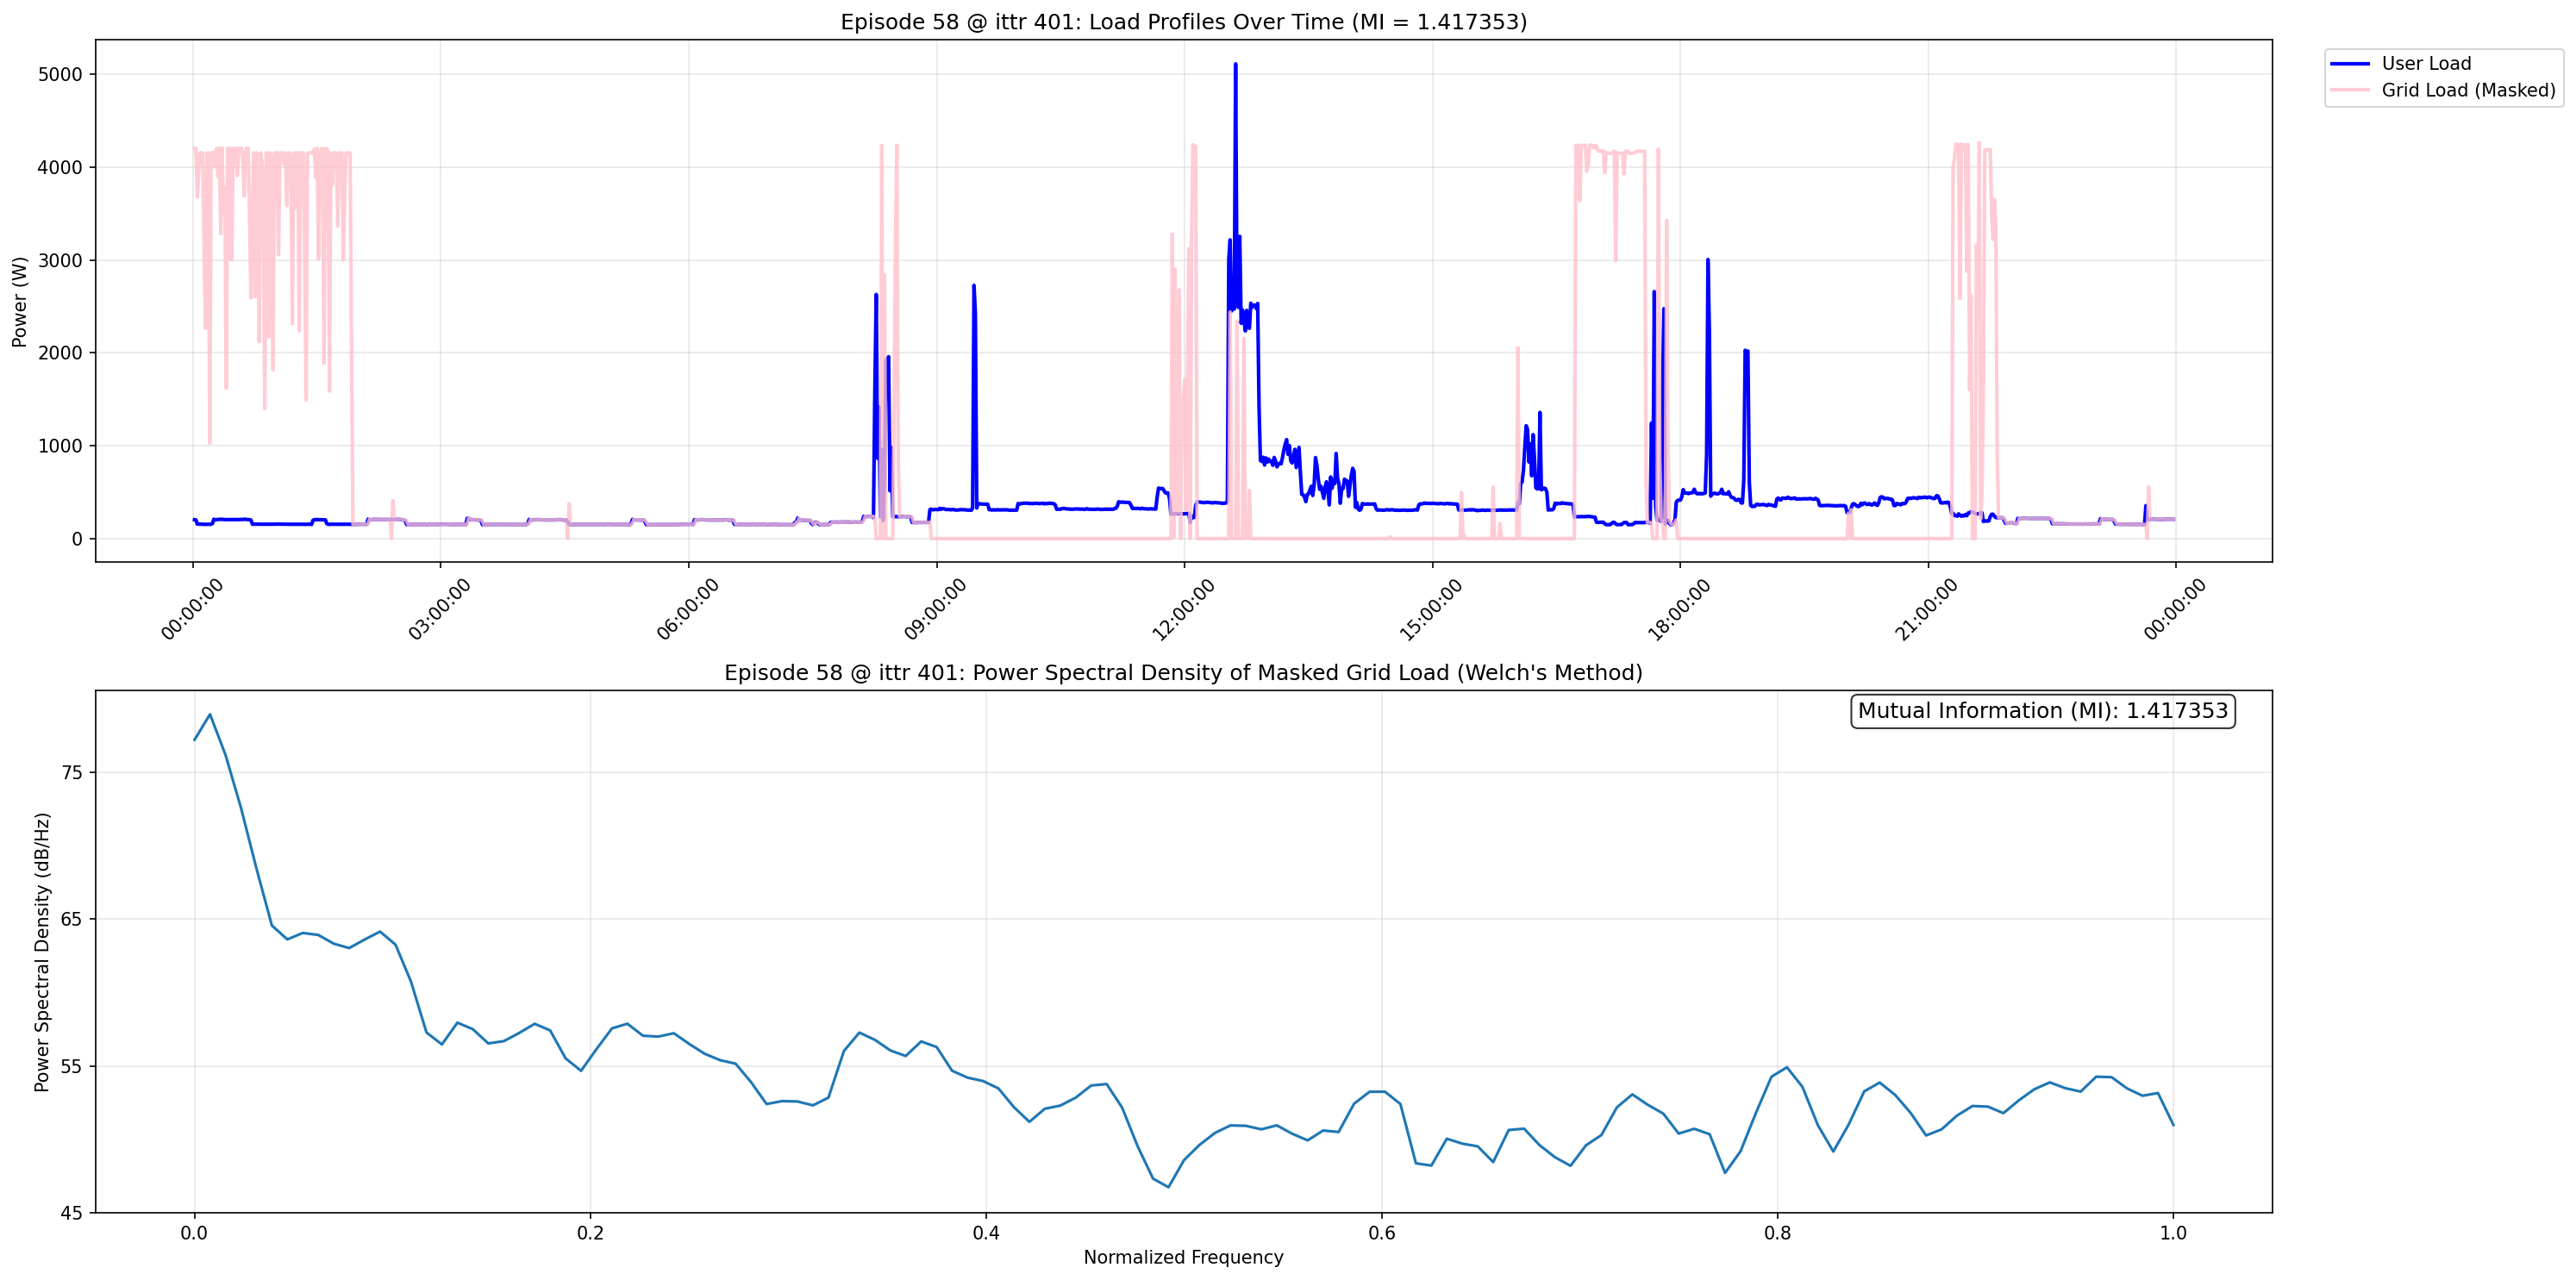

In [38]:
# Example: Plot a specific episode with its mutual information
example_episode_idx = 400  # Change this to plot different episodes

if example_episode_idx < len(episode_info_dfs):
    episode_df = episode_info_dfs[example_episode_idx]
    episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else example_episode_idx
    mi_value = mutual_info_values[example_episode_idx]
    
    print_log(f"Plotting episode {episode_idx} with MI = {mi_value:.6f}")
    
    # Plot with datetime
    fig = plot_episode_with_psd(episode_df, episode_idx, mi_value, use_datetime=True, show=True)
    
    # Optionally save the plot
    # save_path = expt_folder / "graphs" / "mi_analysis" / f"episode_{episode_idx}_with_mi.png"
    # if not save_path.parent.exists():
    #     save_path.parent.mkdir(parents=True)
    # fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.close('all')
else:
    print_log(f"Episode index {example_episode_idx} is out of range. Available episodes: 0 to {len(episode_info_dfs)-1}")

[2025-07-23 15:02:11:518] Summary plot saved to: experiments/20250719_033035/logs_train/graphs/mi_summary_across_episodes.png


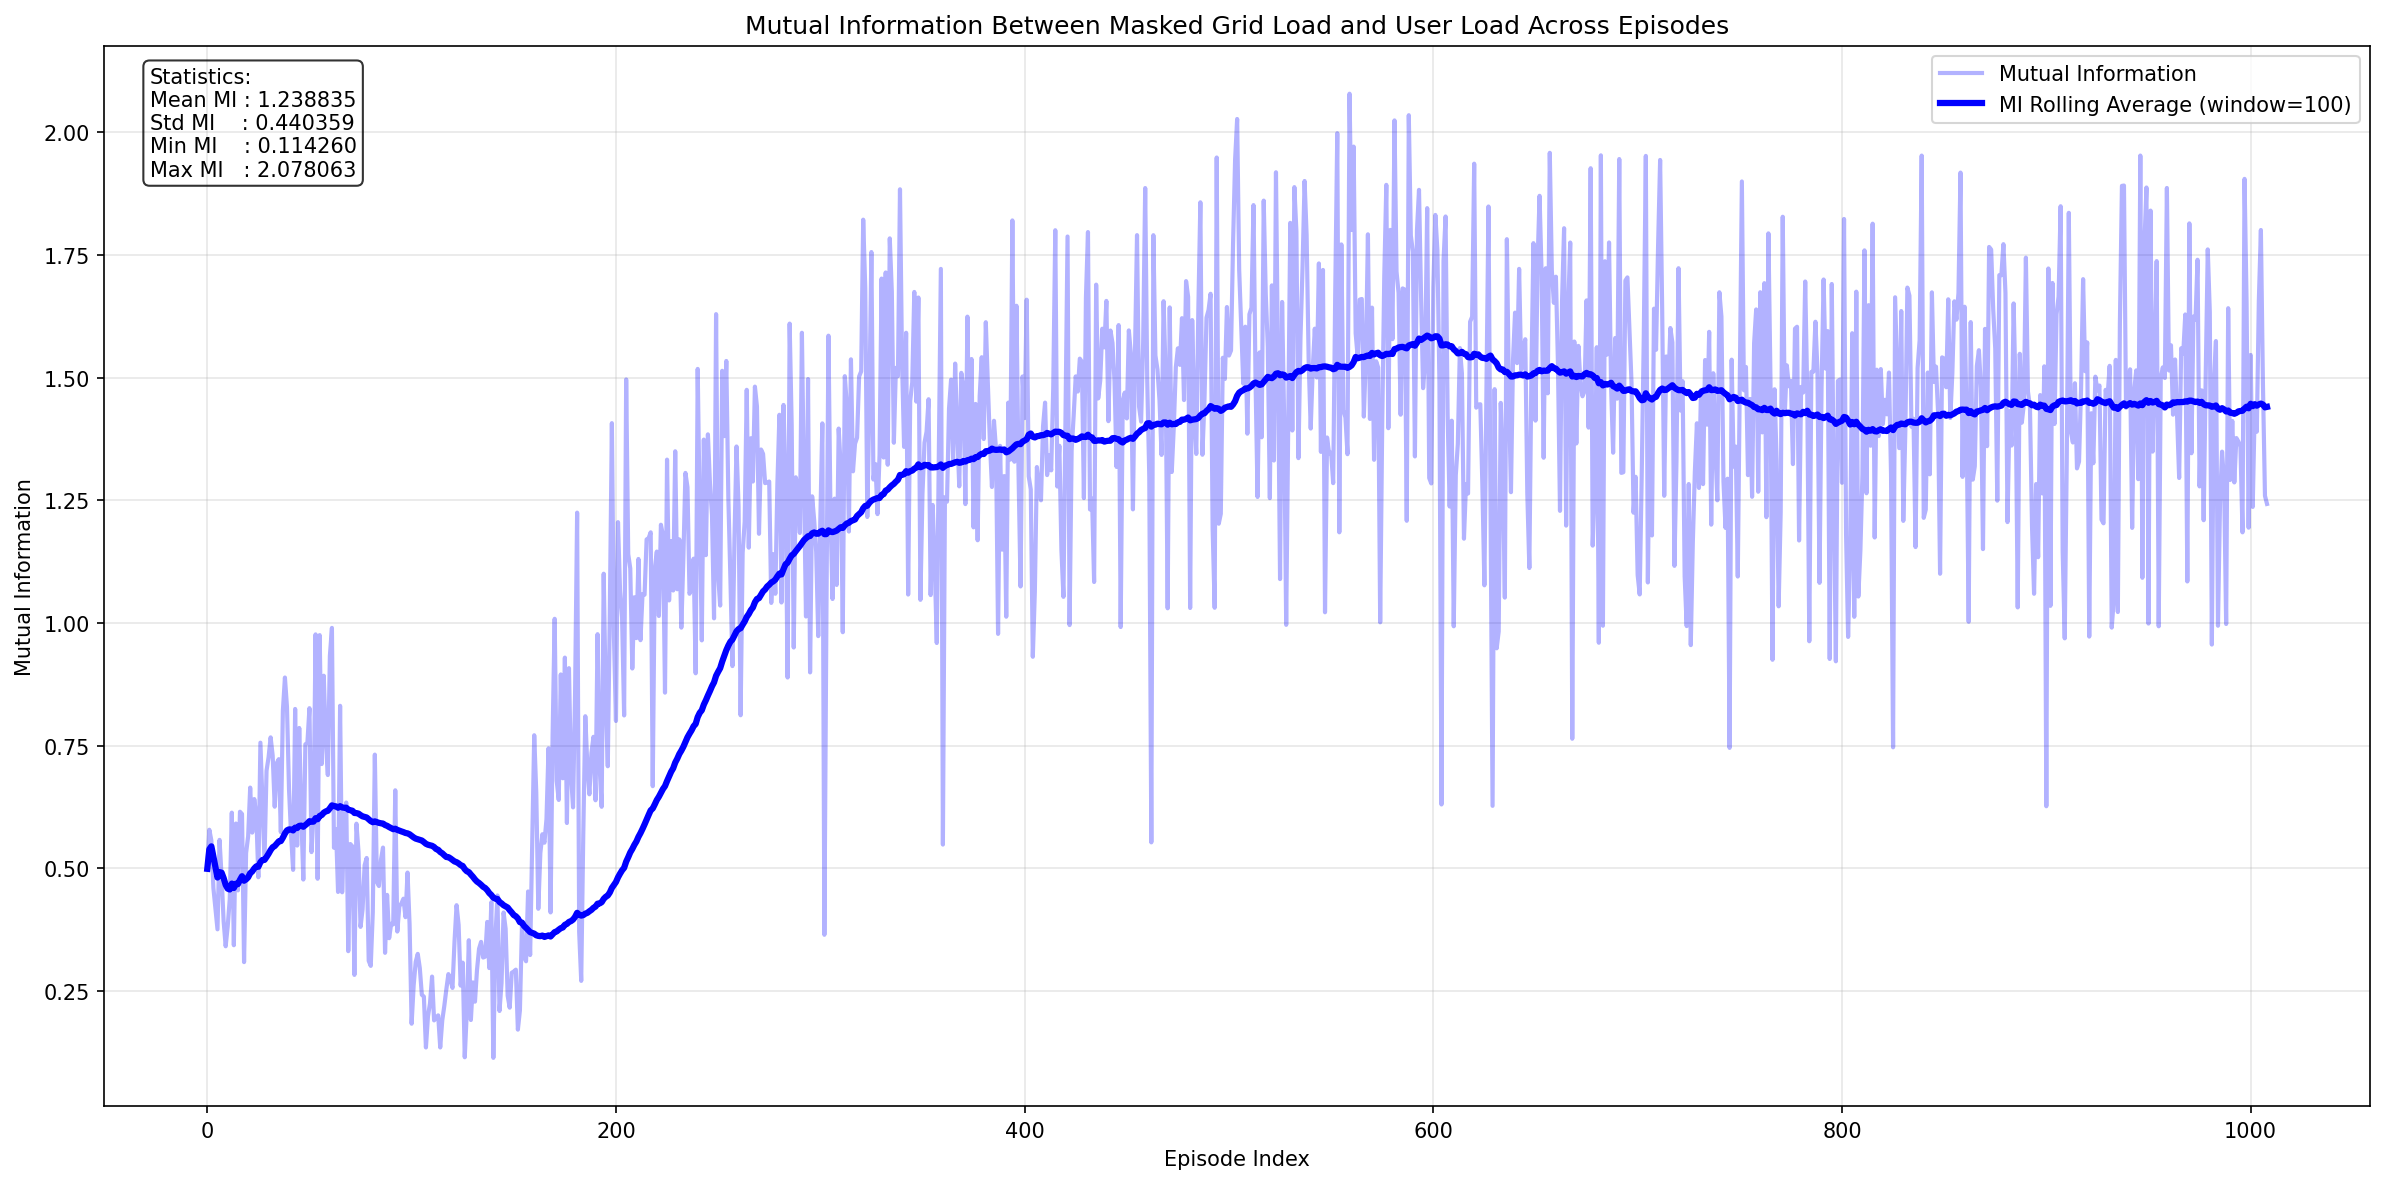

In [39]:
# Create a summary plot of mutual information across all episodes
fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=150)

# Plot mutual information over episodes with light blue color
episode_indices = range(len(mutual_info_values))
sns.lineplot(x=episode_indices, y=mutual_info_values, ax=ax, label='Mutual Information', color='blue', alpha=0.3, linewidth=2)

# Add rolling average (similar to expt_results.ipynb style)
window_size = 100  # Rolling window size
mi_series = pd.Series(mutual_info_values)
mi_rolling = mi_series.rolling(window=window_size, min_periods=1).mean()

sns.lineplot(x=episode_indices, y=mi_rolling, ax=ax, 
             label=f'MI Rolling Average (window={window_size})', 
             color='blue', linewidth=3, alpha=1.0)

ax.set_title('Mutual Information Between Masked Grid Load and User Load Across Episodes')
ax.set_xlabel('Episode Index')
ax.set_ylabel('Mutual Information')
ax.legend()
ax.grid(True, alpha=0.3)

# Add statistics as text with better alignment and transparent background
stats_text = f"""Statistics:
Mean MI : {np.nanmean(mutual_info_values):.6f}
Std MI    : {np.nanstd(mutual_info_values):.6f}
Min MI    : {np.nanmin(mutual_info_values):.6f}
Max MI   : {np.nanmax(mutual_info_values):.6f}"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.8))

plt.tight_layout()

# Save the summary plot
mi_summary_path = expt_folder / "graphs" / "mi_summary_across_episodes.png"
if not mi_summary_path.parent.exists():
    mi_summary_path.parent.mkdir(parents=True)
fig.savefig(mi_summary_path, dpi=300, bbox_inches='tight')
print_log(f"Summary plot saved to: {mi_summary_path}")

plt.show()


[2025-07-23 14:35:41:236] Plotting 5 episodes with MI values...


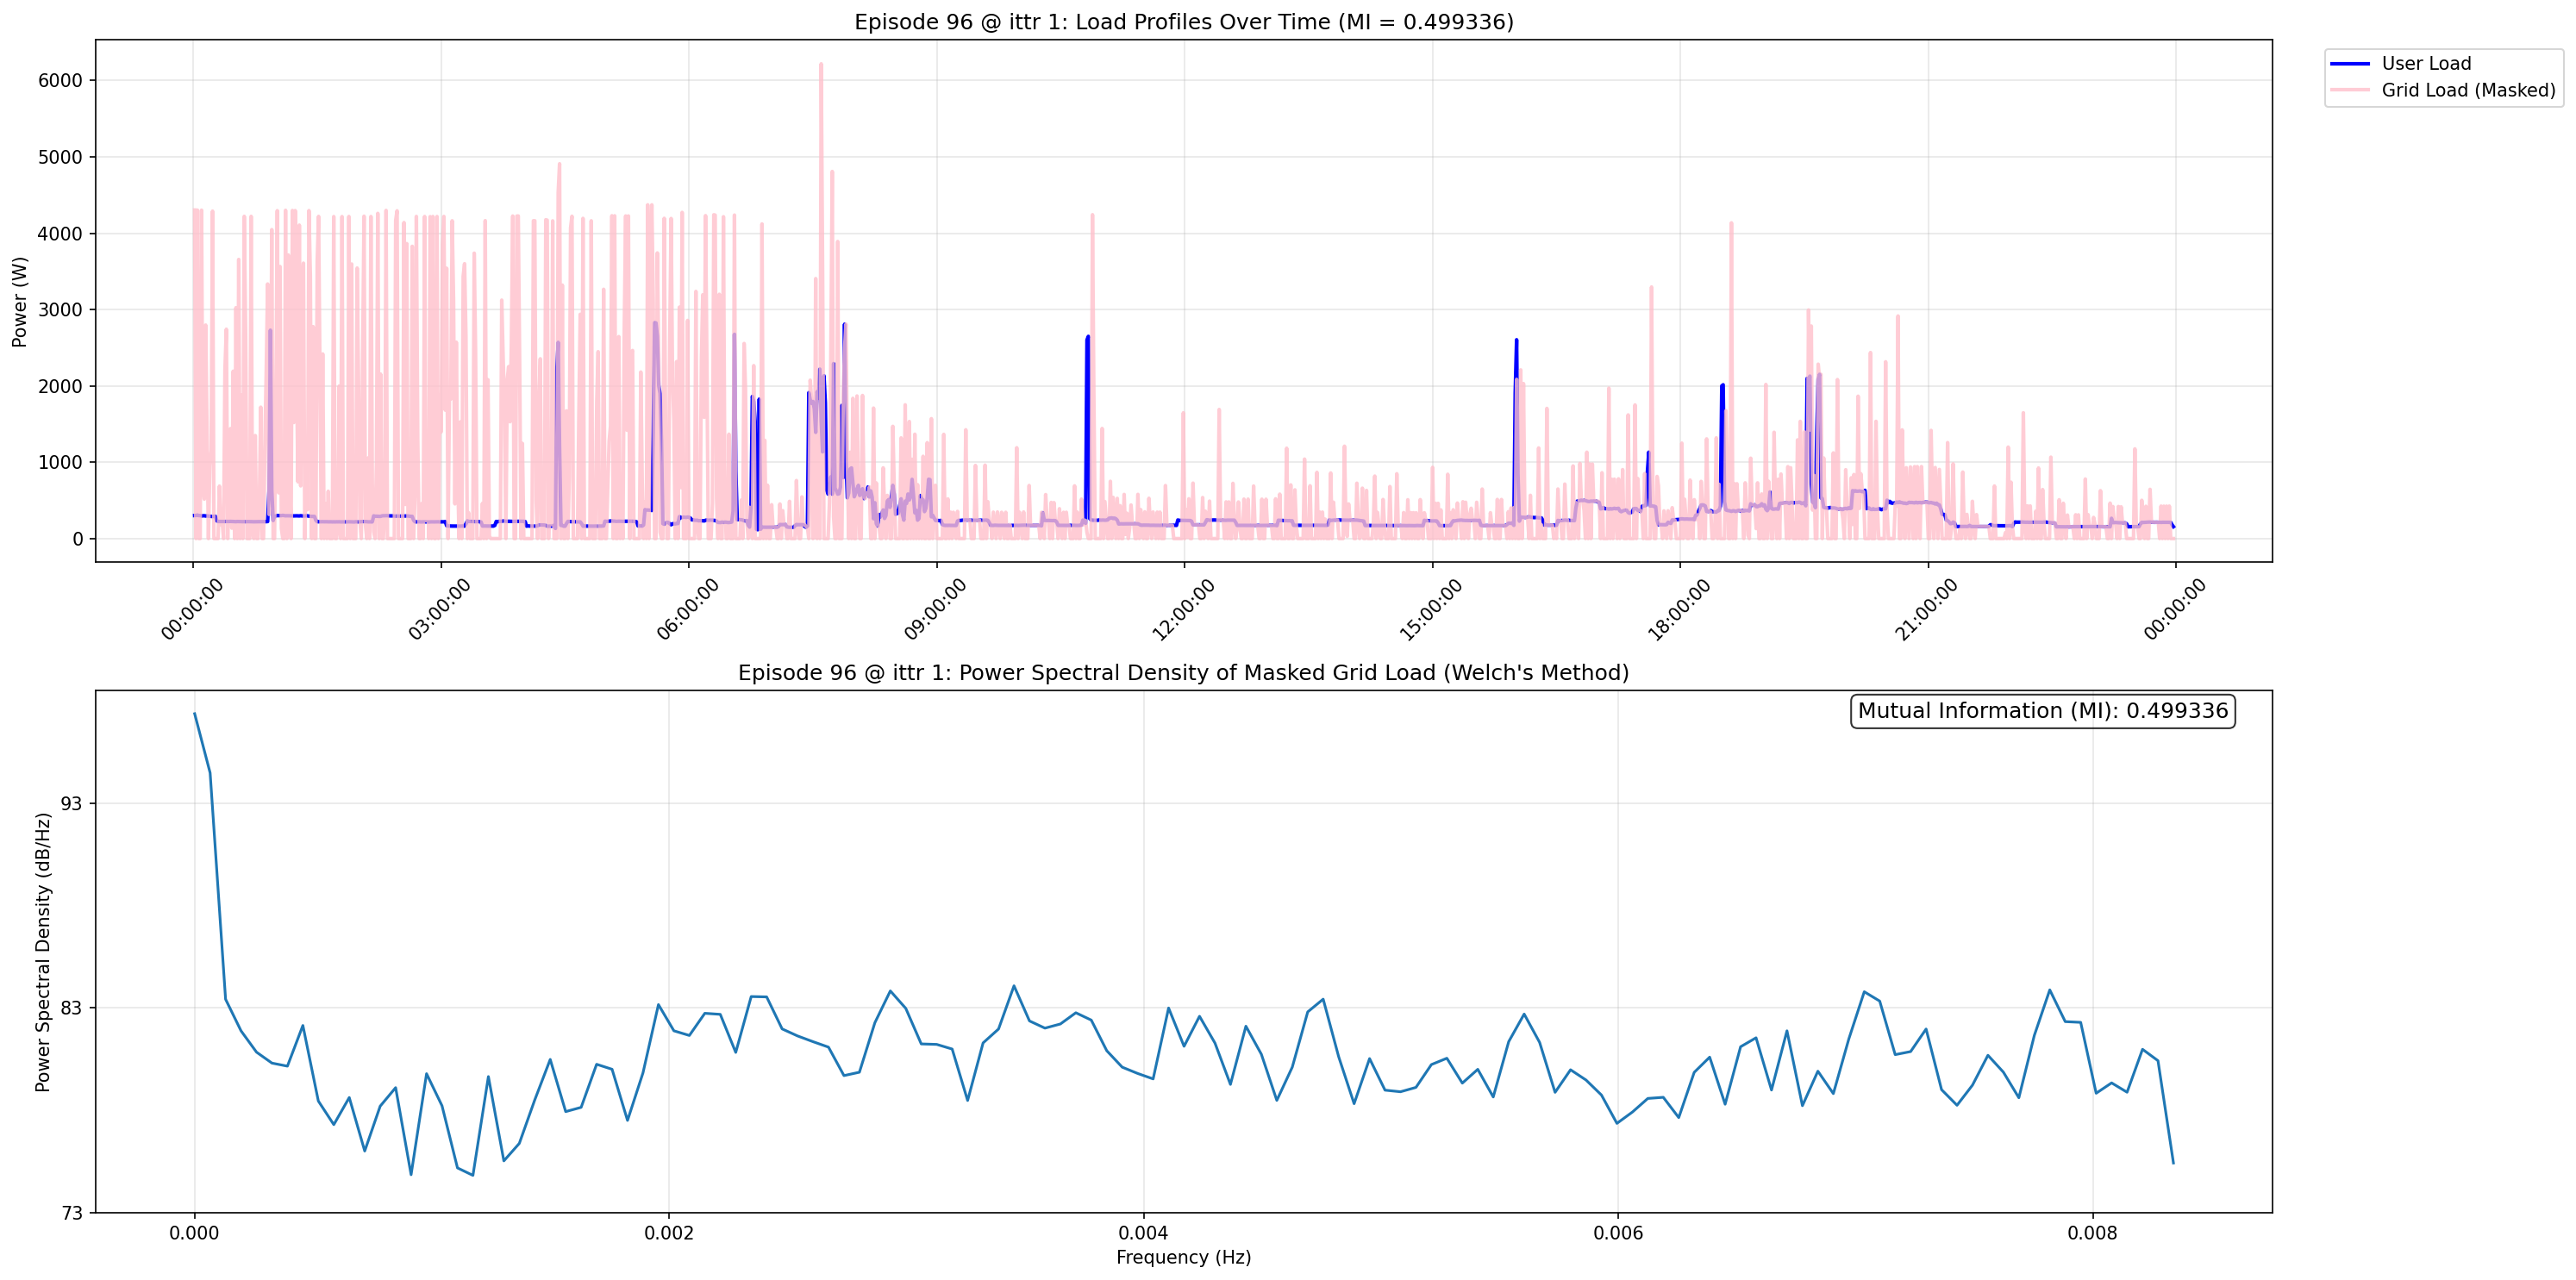

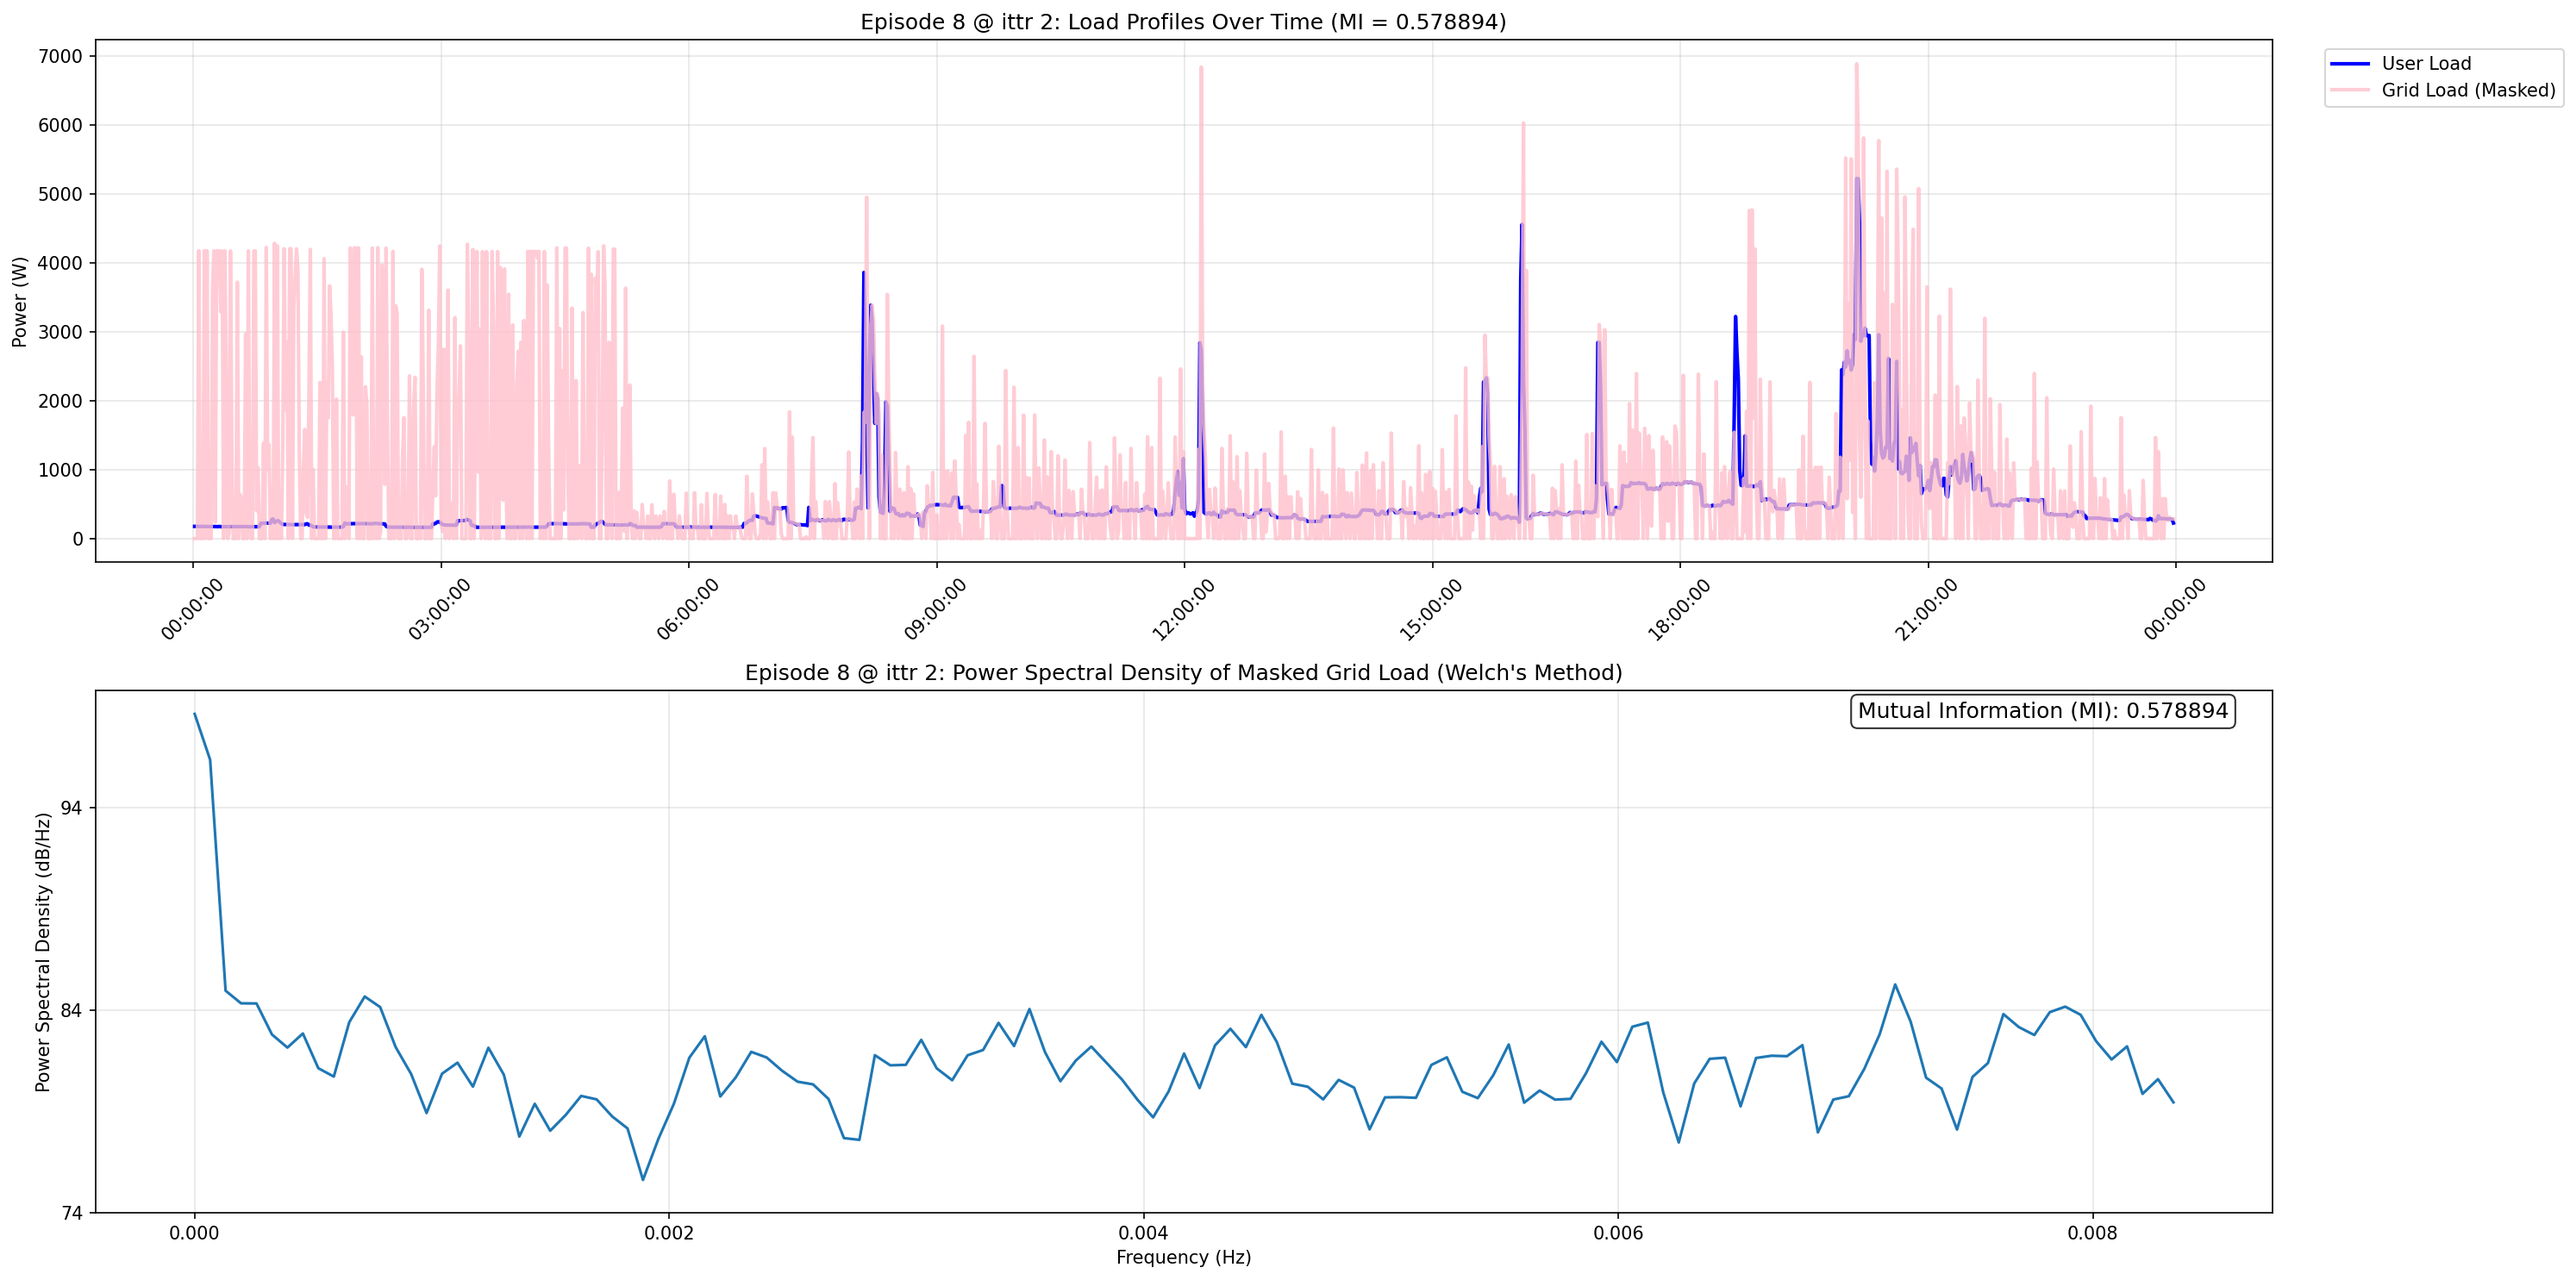

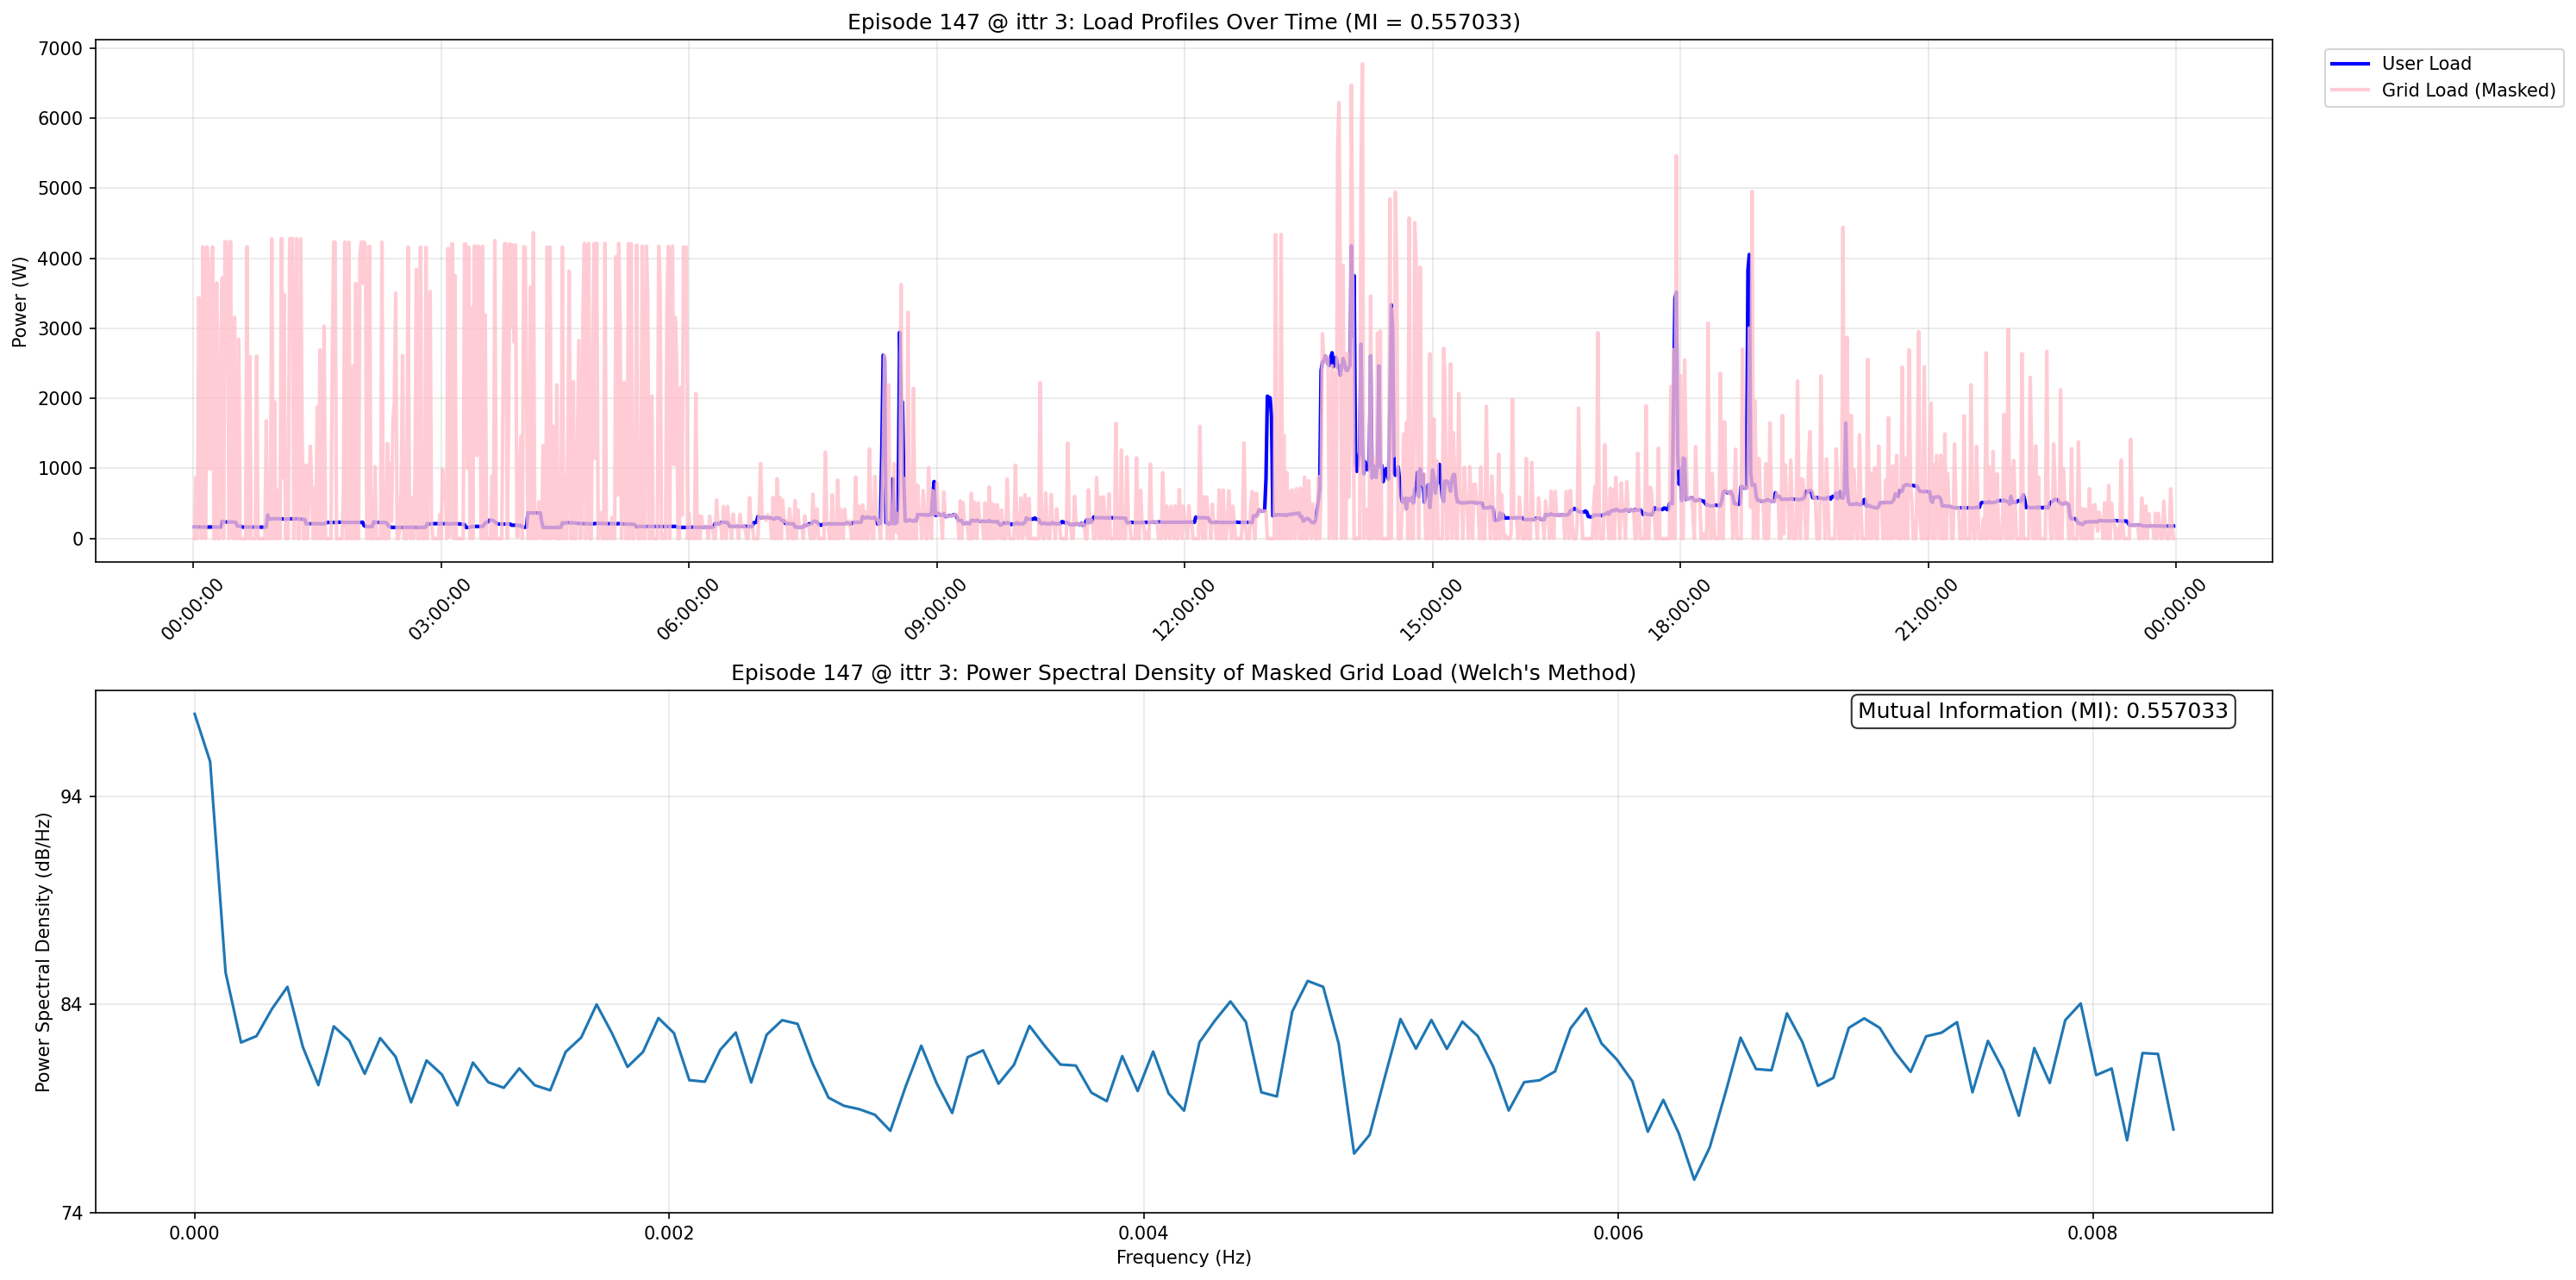

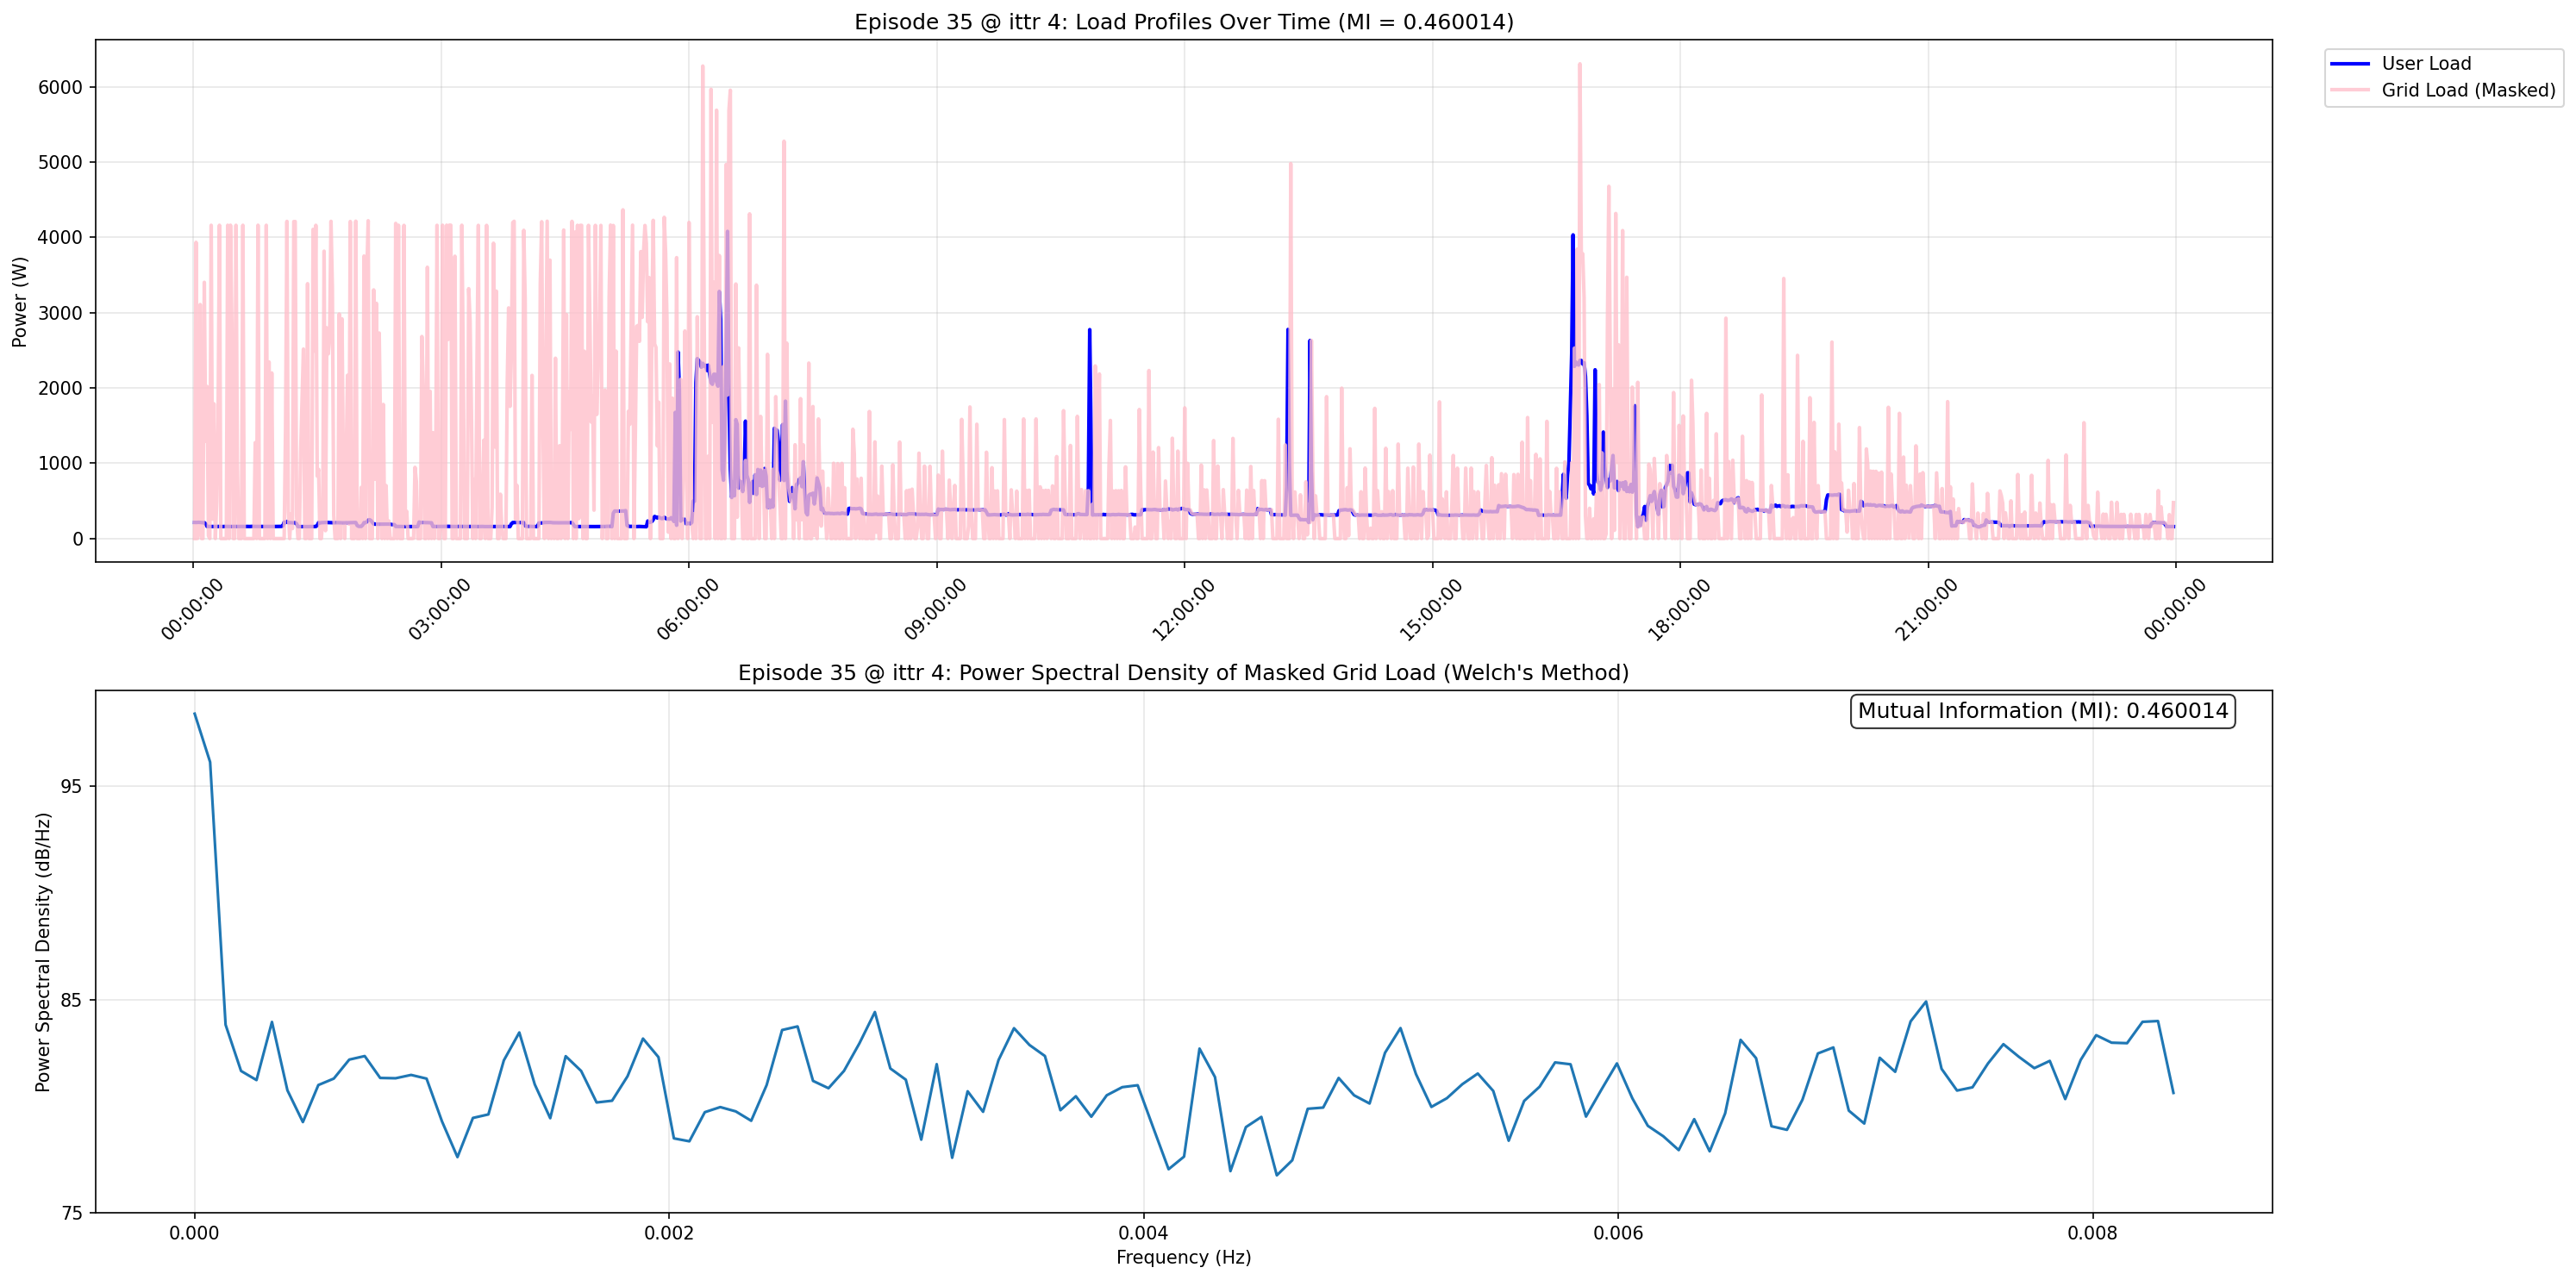

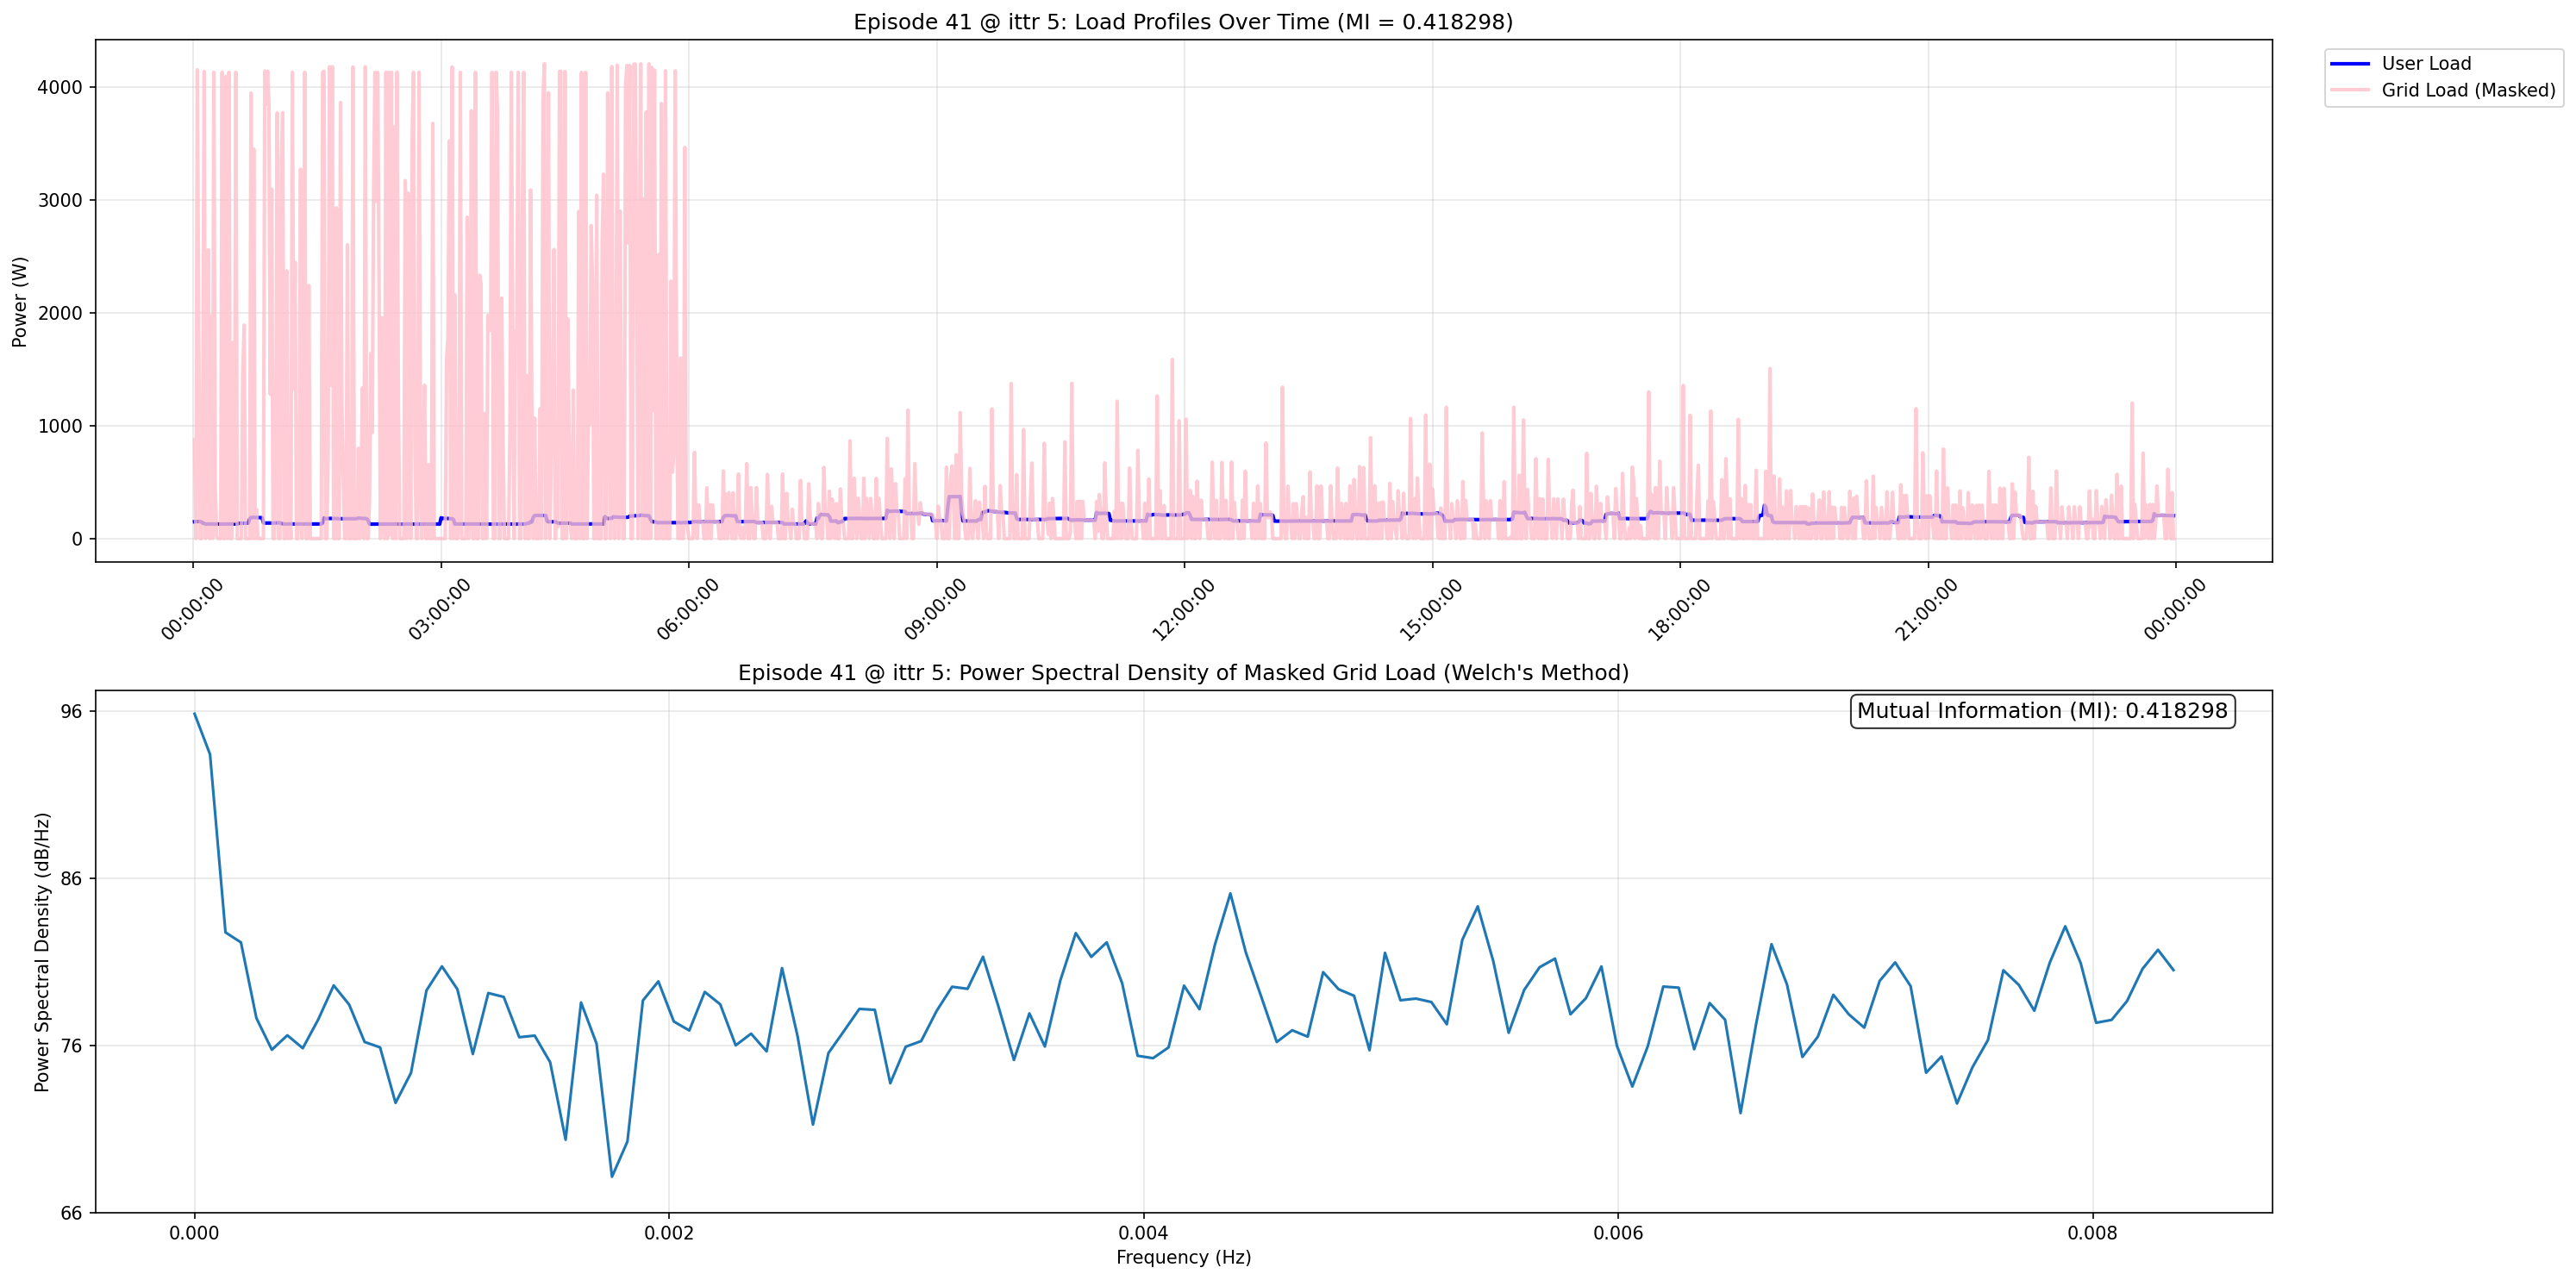

[2025-07-23 14:35:42:427] Completed 5/5 episodes
[2025-07-23 14:35:42:428] Episode plots with MI saved to: experiments/20250719_033035/logs_train/graphs/mi_analysis


In [ ]:
# Function to plot multiple episodes with their MI values and PSD
def plot_multiple_episodes_with_psd(episode_info_dfs, mutual_info_values, episode_indices=None, 
                                   save_folder=None, use_datetime=True, show_plots=False):
    """
    Plot multiple episodes with their mutual information values and PSD analysis
    
    Args:
        episode_info_dfs: List of episode DataFrames
        mutual_info_values: List of mutual information values
        episode_indices: List of episode indices to plot (if None, plots first 10)
        save_folder: Folder to save plots (if None, doesn't save)
        use_datetime: Whether to use datetime for x-axis
        show_plots: Whether to display plots
    """
    if episode_indices is None:
        episode_indices = list(range(min(10, len(episode_info_dfs))))
    
    print_log(f"Plotting {len(episode_indices)} episodes with MI values...")
    
    for i, ep_idx in enumerate(episode_indices):
        if ep_idx >= len(episode_info_dfs):
            print_log(f"Episode index {ep_idx} out of range, skipping...")
            continue
            
        episode_df = episode_info_dfs[ep_idx]
        episode_idx = episode_df['episode_index'].iloc[0] if 'episode_index' in episode_df.columns else ep_idx
        mi_value = mutual_info_values[ep_idx]
        
        # Create save path if folder provided
        save_path = None
        if save_folder:
            save_path = save_folder / f"episode_{episode_idx:04d}_with_MI.png"
            if not save_path.parent.exists():
                save_path.parent.mkdir(parents=True)
        
        # Plot the episode
        fig = plot_episode_with_psd(episode_df, episode_idx, mi_value, 
                                   save_path=save_path, use_datetime=use_datetime, show=show_plots)
        
        # Close figure to save memory
        if not show_plots:
            plt.close(fig)
            
        if (i + 1) % 5 == 0:
            print_log(f"Completed {i + 1}/{len(episode_indices)} episodes")

# Example usage: Plot first 5 episodes and some selected episodes
selected_episodes = [0, 1, 2, 3, 4]  # First 5 episodes

# You can also select episodes with specific MI characteristics
# For example, episodes with highest MI:
# mi_sorted_indices = np.argsort(mutual_info_values)[::-1]  # Sort descending
# selected_episodes = mi_sorted_indices[:5].tolist()  # Top 5 highest MI

# Plot the selected episodes
mi_plots_folder = expt_folder / "graphs" / "MI_analysis"
plot_multiple_episodes_with_psd(episode_info_dfs, mutual_info_values, 
                               episode_indices=selected_episodes,
                               save_folder=mi_plots_folder,
                               use_datetime=True, 
                               show_plots=True)  # Set to True if you want to see plots

print_log(f"Episode plots with MI saved to: {mi_plots_folder}")

## Mutual Information Analysis Results

The mutual information (MI) metric measures the amount of information that the masked grid load reveals about the user load. Lower MI values indicate better privacy protection.

Key insights from the analysis:
- **MI = 0**: Perfect privacy - masked grid load reveals no information about user load
- **Higher MI values**: More information leakage - the masking is less effective
- **MI trends over episodes**: Shows how the RL agent learns to balance privacy vs. cost

The plots above show:
1. **Load profiles**: Comparison between actual user load and masked grid load
2. **MI visualization**: The mutual information level for each episode, displayed as a constant line since MI is calculated per episode

This analysis helps evaluate the privacy-preserving effectiveness of the adversarial smart meter control system.